In [1]:
import os
import cv2
import numpy as np
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from metrics import top_3_acc
from os import listdir
from PIL import Image, ImageFile
import pdb
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn import metrics
from tensorflow.python.framework import ops
import pylab as pl
from keras.layers.core import Lambda
from keras.models import Sequential
import keras.backend as K
import tensorflow as tf
import keras
from keras.layers.core import Lambda

from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

%matplotlib inline

/home/bartol/.virtual_envs/mozgalo/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
labels = {'HyVee': 8, 'Target': 19, 'CVSPharmacy': 2, 
          'Wegmans': 22, 'HEB': 6, 'StopShop': 18, 'BJs': 1, 
          'Albertsons': 0, 'FredMeyer': 4, 'Walgreens': 20, 
          'KingSoopers': 10, 'Walmart': 21, 'Safeway': 14, 
          'ShopRite': 16, 'Costco': 3, 'SamsClub': 15, 
          'WinCoFoods': 24, 'HarrisTeeter': 7, 'WholeFoodsMarket': 23,
          'Kroger': 11, 'Smiths': 17, 'Meijer': 12, 
          'Publix': 13, 'Frys': 5, 'JewelOsco': 9}

class_labels = {v: k for k, v in labels.items()}

In [3]:
from keras.models import model_from_json
json_file = open('../models/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("../models/weights_ep18.hd5f")
print("Loaded model from disk")

Loaded model from disk


In [50]:
def normalize_input(image):
    image /= 255.
    image -= 0.5

    return image
    
def crop_upper_part(image, percent=0.4):
    height, _, _ = image.shape
    point = int(percent * height)
    return image[:point, :]

def load_image(img):
    img = crop_upper_part(img, 0.5)    
    #img = normalize_input(img.astype(np.float32))
    img = cv2.resize(img, input_size)
    return np.expand_dims(img, 0)

def target_category_loss(x, category_index, nb_classes):
    return tf.multiply(x, K.one_hot([category_index], nb_classes))

def target_category_loss_output_shape(input_shape):
    return input_shape

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)


def grad_cam(input_model, image, category_index, layer_name, nb_classes=25):
    target_layer = lambda x: target_category_loss(x, category_index, nb_classes)

    x = input_model.layers[-1].output
    x = Lambda(target_layer, output_shape=target_category_loss_output_shape)(x)
    model = keras.models.Model(input_model.layers[0].input, x)

    loss = K.mean(model.layers[-1].output)

    conv_output = [l for l in model.layers if l.name == layer_name][0].output
    grads = normalize(K.gradients(loss, conv_output)[0])
    gradient_function = K.function([model.layers[0].input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam, (input_size))
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)

    #Return to BGR [0..255] from the preprocessed image
    image = image[0, :]
    image -= np.min(image)
    image = np.minimum(image, 255)

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    cam = np.float32(cam) + np.float32(image)
    cam = 255 * cam / np.max(cam)
    return np.uint8(cam)[:, :, :], heatmap

[[5.26867676e-19 2.62813444e-15 2.86925302e-20 1.12773115e-17
  7.32600006e-20 6.47816113e-19 7.83617352e-14 2.41552091e-17
  5.04420131e-17 1.49301108e-15 9.98546422e-01 2.64849309e-16
  9.57874115e-19 2.41949347e-19 9.95701986e-17 4.96626336e-17
  2.03167305e-09 2.42889680e-20 1.85513137e-20 2.64496808e-17
  5.43967323e-13 4.40907200e-10 5.75707491e-18 1.39764513e-16
  2.55914275e-19]]
KingSoopers


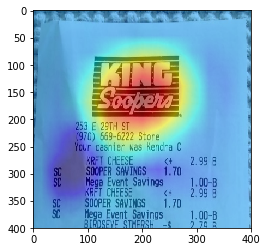

In [49]:
input_size = (400,  400)
img_path = "/home/bartol/Work/mozgalo-mb/src/data/test/KingSoopers/4943.jpg"

preprocessed_input = load_image(cv2.imread(img_path))

predictions = model.predict(preprocessed_input)

print(predictions)
predicted_class = np.argmax(predictions)
print(class_labels[predicted_class])


cam, heatmap = grad_cam(model, preprocessed_input, predicted_class, "block14_sepconv2_act")
cv2.imwrite("ksoopers.jpg", cam)
plt.imshow(cam)
plt.show()